
## Script to get data from the Datacube Chile Platform (https://datacubechile.cl/) and process Land surface phenology variables  

LSP variables obgained using the repo: https://github.com/JavierLopatin/PhenoPY

Author: Javier Lopatin \
Date: 2025-11-10 \
Version: 1.0 \
Description: This script is used to get data from the Datacube Platform. \
using the Datacube API. \
The script is used to get data for the PhenoPY project.   


In [1]:
# For testing inside the Datacube Platform!
%matplotlib inline
%load_ext autoreload
%autoreload 2
import datacube
import numpy as np
import sys, os
import xarray as xr
import rioxarray as rio
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.masking import make_mask, mask_invalid_data, describe_variable_flags
from datacube.utils.rio import configure_s3_access
from dask.distributed import Client

sys.path.append('PhenoPy/')
from phenoxr.phenoXr import Pheno
sys.path.append('../')

client = Client()
client

configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)
# configure_s3_access(aws_unsigned=False, requester_pays=True)

dc = datacube.Datacube(app="Pheno_test")
dc.list_products().name

/tmp/ipykernel_89/312319109.py:10: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


name
copernicus_dem_30    copernicus_dem_30
copernicus_dem_90    copernicus_dem_90
landsat5_c2l2_sr      landsat5_c2l2_sr
landsat5_c2l2_st      landsat5_c2l2_st
landsat7_c2l2_sr      landsat7_c2l2_sr
landsat7_c2l2_st      landsat7_c2l2_st
landsat8_c2l1            landsat8_c2l1
landsat8_c2l2_sr      landsat8_c2l2_sr
landsat8_c2l2_st      landsat8_c2l2_st
landsat9_c2l1            landsat9_c2l1
landsat9_c2l2_sr      landsat9_c2l2_sr
landsat9_c2l2_st      landsat9_c2l2_st
lpdaac_nasadem          lpdaac_nasadem
s1_rtc                          s1_rtc
s2_l2a                          s2_l2a
Name: name, dtype: object

In [7]:
os.getcwd()

'/home/jovyan/WetlandPhenology'

In [2]:
# load shapefile and get dimesnsion 
shp = gpd.read_file('SHP/Suisun_mask.shp')
print(shp.crs)
# get shapefile dimesions from shp
shp_bouning_box = shp.total_bounds

/env/lib/python3.10/site-packages/pygeos/io.py:89: UserWarning: The shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the PyGEOS GEOS version (3.10.2-CAPI-1.16.0). Conversions between both will be slow
  warnings.warn(


epsg:32610


In [3]:
# get coordinates of the shapefile bounding box
X_min = shp_bouning_box[0]
X_max = shp_bouning_box[2]
Y_min = shp_bouning_box[1]
Y_max = shp_bouning_box[3]

In [4]:
# list of the X and Y coordinates with a grid of 4 blocks
X_list = np.linspace(X_min, X_max, 6)
X_list
# Y_list = np.linspace(Y_min, Y_max, 4)

array([575577.79687636, 580634.44146272, 585691.08604909, 590747.73063545,
       595804.37522182, 600861.01980818])

In [5]:
print(Y_min)
print(Y_max)

4214209.236425046
4228094.777737682


In [ ]:
CRS = 'EPSG:32610'

query = {
    'product': "s2_l2a", # Sentinel-2 Level-2A product
    "x": (X_min, X_max), # X coordinates of the grid
    "y": (Y_min, Y_max), # Y coordinates of the grid
    "time": ('2018-01-01', '2020-12-31'), # Time range of the data to be obtained
    "output_crs": CRS, # output oordinate Reference System
    "resolution": (-10, 10), # Resolution of the data to be obtained
    "dask_chunks": {"time":1, "x":350, "y":300}, # Dask chunks of the data to be obtained
    "group_by":"solar_day", # Group by solar day
    'skip_broken_datasets': True, # Skip broken datasets
    'crs': CRS, # Coordinate Reference System
    'measurements': ['B04', 'B08', 'SCL'], # Bands to be obtained
}

ds_s2 = dc.load(
    **query,
)

ds_s2

<xarray.Dataset>
Dimensions:      (time: 202, y: 2243, x: 2530)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-10T19:02:32 ... 2020-12-30T19:...
  * y            (y) float64 4.234e+06 4.234e+06 ... 4.211e+06 4.211e+06
  * x            (x) float64 5.756e+05 5.756e+05 ... 6.009e+05 6.009e+05
    spatial_ref  int32 32610
Data variables:
    B04          (time, y, x) uint16 dask.array<chunksize=(1, 300, 350), meta=np.ndarray>
    B08          (time, y, x) uint16 dask.array<chunksize=(1, 300, 350), meta=np.ndarray>
    SCL          (time, y, x) uint8 dask.array<chunksize=(1, 300, 350), meta=np.ndarray>
Attributes:
    crs:           EPSG:32610
    grid_mapping:  spatial_ref

In [7]:
# load functions to see quality flags
from datacube.utils import masking

masking.describe_variable_flags(ds_s2.SCL).values

array([[list([0, 1, 2, 3, 4, 5, 6, 7]),
        {'0': 'no data', '1': 'saturated or defective', '2': 'dark area pixels', '3': 'cloud shadows', '4': 'vegetation', '5': 'bare soils', '6': 'water', '7': 'unclassified', '8': 'cloud medium probability', '9': 'cloud high probability', '10': 'thin cirrus', '11': 'snow or ice'},
        'Sen2Cor Scene Classification']], dtype=object)

In [8]:
# Multiple flags are combined as logial OR using the | symbol
cloud_free_mask = (
    masking.make_mask(ds_s2.SCL, qa="vegetation") | 
    masking.make_mask(ds_s2.SCL, qa="bare soils") |
    masking.make_mask(ds_s2.SCL, qa="water") |
    masking.make_mask(ds_s2.SCL, qa="snow or ice")
)

cloud_free_mask

<xarray.DataArray 'SCL' (time: 202, y: 2243, x: 2530)>
dask.array<or_, shape=(202, 2243, 2530), dtype=bool, chunksize=(1, 300, 350), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2018-01-10T19:02:32 ... 2020-12-30T19:...
  * y            (y) float64 4.234e+06 4.234e+06 ... 4.211e+06 4.211e+06
  * x            (x) float64 5.756e+05 5.756e+05 ... 6.009e+05 6.009e+05
    spatial_ref  int32 32610

In [9]:
# Calculate proportion of good pixels
valid_pixel_proportion = cloud_free_mask.sum(dim=("x", "y"))/(cloud_free_mask.shape[1] * cloud_free_mask.shape[2])
valid_threshold = 0.7
observations_to_keep = (valid_pixel_proportion >= valid_threshold)

# Mask the data
ds_s2_valid = ds_s2.where(cloud_free_mask)

# only keep observations above the good pixel proportion threshold
# The .compute() step means the values will be loaded into memory. This step may take some time
ds_s2_keep = ds_s2_valid.sel(time=observations_to_keep)#.compute()
ds_s2_keep

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


<xarray.Dataset>
Dimensions:      (time: 124, y: 2243, x: 2530)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-20T18:57:04 ... 2020-12-30T19:...
  * y            (y) float64 4.234e+06 4.234e+06 ... 4.211e+06 4.211e+06
  * x            (x) float64 5.756e+05 5.756e+05 ... 6.009e+05 6.009e+05
    spatial_ref  int32 32610
Data variables:
    B04          (time, y, x) float64 dask.array<chunksize=(1, 300, 350), meta=np.ndarray>
    B08          (time, y, x) float64 dask.array<chunksize=(1, 300, 350), meta=np.ndarray>
    SCL          (time, y, x) float64 dask.array<chunksize=(1, 300, 350), meta=np.ndarray>
Attributes:
    crs:           EPSG:32610
    grid_mapping:  spatial_ref

In [10]:
# order ds_s2_keep by day of year
ds_s2_keep = ds_s2_keep.sortby(ds_s2_keep.time.dt.dayofyear)
doy=ds_s2_keep.time.dt.dayofyear.values
doy

array([  5,  10,  20,  25,  40,  40,  50,  50,  50,  55,  60,  65,  70,
        75,  80,  80,  85,  85,  90, 100, 105, 105, 110, 110, 115, 115,
       115, 120, 125, 125, 130, 145, 150, 155, 155, 155, 160, 160, 165,
       165, 165, 170, 170, 170, 175, 175, 180, 180, 185, 185, 185, 190,
       190, 190, 195, 195, 195, 200, 200, 200, 205, 205, 205, 210, 210,
       215, 215, 215, 220, 220, 220, 225, 225, 225, 230, 230, 235, 235,
       235, 240, 240, 245, 245, 245, 250, 255, 260, 260, 265, 265, 270,
       275, 280, 280, 280, 285, 285, 285, 290, 290, 290, 295, 295, 295,
       300, 300, 305, 305, 310, 310, 310, 320, 320, 325, 325, 330, 335,
       340, 345, 350, 360, 360, 365, 365])

In [ ]:
# calculate EVI Index for each observation using the formula EVI = 2.5 * (NIR - R) / (NIR + (2.4 * R) + 1)
ds_s2_keep['EVI'] = (2.5 * (ds_s2_keep.B08 - ds_s2_keep.B04)) / (ds_s2_keep.B08 + (2.4 * ds_s2_keep.B04) + 1)
ds_s2_keep

<xarray.Dataset>
Dimensions:      (time: 124, y: 2243, x: 2530)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-05T19:03:46 ... 2020-12-30T19:...
  * y            (y) float64 4.234e+06 4.234e+06 ... 4.211e+06 4.211e+06
  * x            (x) float64 5.756e+05 5.756e+05 ... 6.009e+05 6.009e+05
    spatial_ref  int32 32610
Data variables:
    B04          (time, y, x) float64 dask.array<chunksize=(1, 300, 350), meta=np.ndarray>
    B08          (time, y, x) float64 dask.array<chunksize=(1, 300, 350), meta=np.ndarray>
    SCL          (time, y, x) float64 dask.array<chunksize=(1, 300, 350), meta=np.ndarray>
    EVI          (time, y, x) float64 dask.array<chunksize=(1, 300, 350), meta=np.ndarray>
Attributes:
    crs:           EPSG:32610
    grid_mapping:  spatial_ref

In [ ]:
# save EVI stack
#ds_s2_keep.EVI.rio.to_raster("Outputs/EVIStack.tif")

In [12]:
###################################################
# PhenoShape
###################################################
phenoshape = ds_s2_keep.EVI.pheno.PhenoShape().compute()
phenoshape

<xarray.DataArray (doy: 52, y: 2243, x: 2530)>
array([[[ 1.33166401,  1.00147481,  0.91612052, ...,  0.96673067,
          0.87047593,  0.86896528],
        [ 1.33751026,  1.13178421,  1.10632282, ...,  0.83852671,
          0.80763715,  0.77501259],
        [ 1.05708245,  1.1301874 ,  1.15836684, ...,  0.82595309,
          0.80287533,  0.77949387],
        ...,
        [ 0.79238131,  0.42266638,  1.07032635, ...,  1.26689849,
          1.37072685,  1.69930467],
        [ 0.8690143 ,  0.68410568,  1.02021656, ..., -0.05162242,
          0.12858802,  0.77427149],
        [ 0.81915447,  0.6463072 ,  0.66599069, ..., -0.02230815,
         -0.07732897,  1.04842139]],

       [[ 1.21117746,  1.06222945,  0.95323749, ...,  1.08084801,
          0.99998068,  0.97833331],
        [ 1.30136253,  1.20051562,  1.08326151, ...,  0.93223465,
          0.82346329,  0.85539477],
        [ 1.22947103,  1.21824764,  1.17561417, ...,  0.88833879,
          0.84851354,  0.82377845],
...
        [ 0.4373372 ,  0.28281592,  0.61481641, ...,  1.54179202,
          1.42481554,  1.22435975],
        [ 0.69611595,  0.50656739,  0.94708107, ...,  1.55294365,
          1.42897077,  1.05736033],
        [ 0.77050785,  0.7371573 ,  0.83547193, ...,  1.48822773,
          1.09335164,  1.18715084]],

       [[ 1.35942635,  0.99864699,  0.9036438 , ...,  0.56714212,
          0.46222324,  0.41449012],
        [ 1.06235165,  1.00873849,  1.01743303, ...,  0.45498194,
          0.46430969,  0.4091214 ],
        [ 0.87475739,  0.94338328,  0.9729927 , ...,  0.45808317,
          0.46634594,  0.44300601],
        ...,
        [ 0.73888919,  0.63297331,  0.92444606, ...,  1.54179202,
          1.42481554,  1.22435975],
        [ 0.74101984,  0.83473127,  0.7959343 , ...,  1.55294365,
          1.42897077,  1.05736033],
        [ 0.65637007,  0.77456102,  0.50085759, ...,  1.48822773,
          1.09335164,  1.18715084]]])
Coordinates:
  * doy      (doy) int64 5 12 19 26 33 40 47 54 ... 322 329 336 343 350 357 365
  * y        (y) float64 4.234e+06 4.234e+06 4.234e+06 ... 4.211e+06 4.211e+06
  * x        (x) float64 5.756e+05 5.756e+05 5.756e+05 ... 6.009e+05 6.009e+05

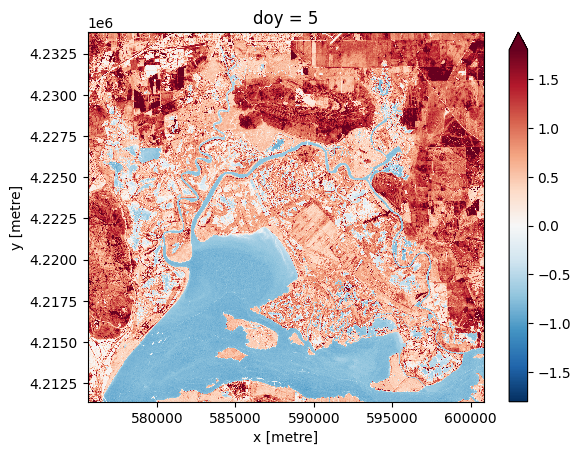

In [15]:
# plot the example date
phenoshape.isel(doy=0).plot(robust=True)

In [19]:
# save to disk
phenoshape.rio.write_crs(CRS).rio.to_raster("Outputs/phenoshapeALL.tif")

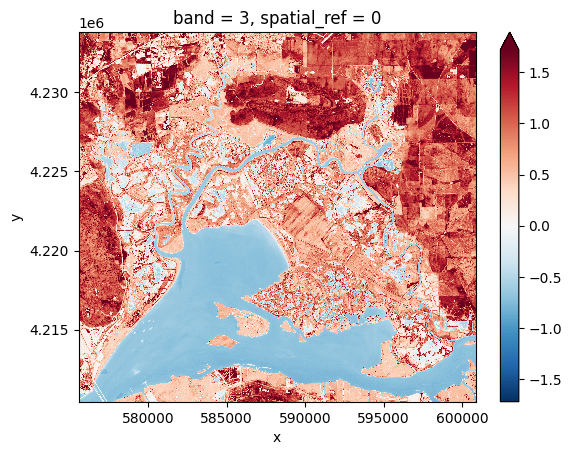

In [28]:
# verify output
out = rio.open_rasterio("Outputs/phenoshapeALL.tif")
out.isel(band=2).plot(robust=True)

In [ ]:
###################################################
# get LSP
###################################################
LSP = phenoshape.pheno.PhenoLSP()#.persist()
LSP

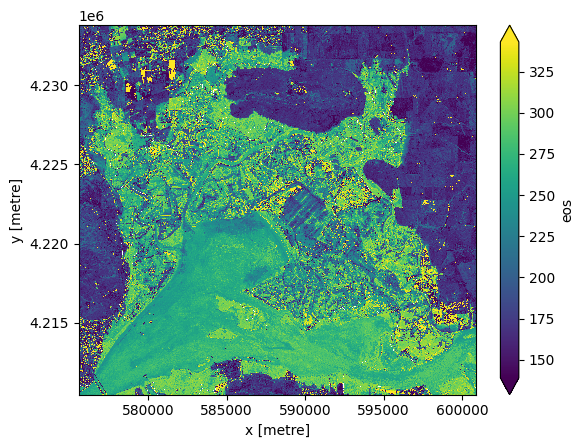

In [25]:
# plot the example date
LSP.eos.plot(robust=True)

In [26]:
# save to disk
LSP.rio.write_crs(CRS).rio.to_raster("Outputs/lspALL.tif")

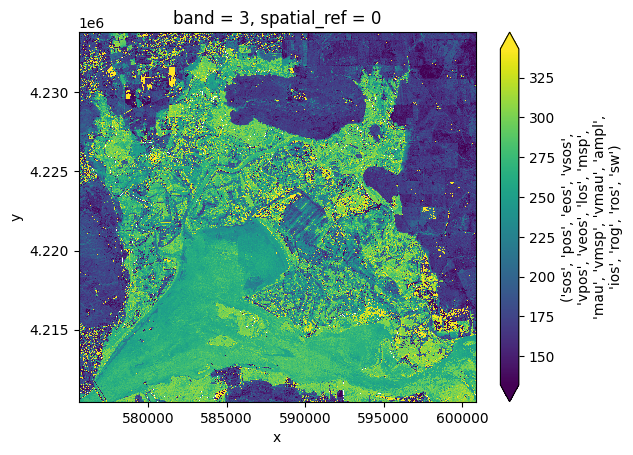

In [23]:
# verify output
out = rio.open_rasterio("Outputs/lspAll.tif")
out.isel(band=2).plot(robust=True)

In [19]:
ds_s2_keep.EVI.persist()

,Array,Chunk
Bytes,5.46 GiB,820.31 kiB
Shape,"(124, 2337, 2530)","(1, 300, 350)"
Count,1 Graph Layer,7936 Chunks
Type,float64,numpy.ndarray


In [ ]:
###################################################
# RMSE of the phenological shapes, segmanted
###################################################
# load inputs externally if crushed 
phenoshape = rio.open_rasterio("Outputs/phenoshapeALL.tif", chunks = {'x':350, 'y':350})
LSP        = rio.open_rasterio("Outputs/lspAll.tif", chunks = {'x':350, 'y':350})
EVI        = rio.open_rasterio("Outputs/EVIStack.tif", chunks = {'x':350, 'y':350})


doy=[5,  12,  19,  26,  33,  40,  47,  54,  61,  68,  75,  82,  89,  96,
       103, 110, 117, 125, 132, 139, 146, 153, 160, 167, 174, 181, 188, 195,
       202, 209, 216, 223, 230, 237, 245, 252, 259, 266, 273, 280, 287, 294,
       301, 308, 315, 322, 329, 336, 343, 350, 357, 365]
phenoshape.assign_coords(band=doy)

# Rename the 'band' dimension to 'doy'
phenoshape = phenoshape.rename({"band": "doy"})

#phenoshape
# process
rmse = phenoshape.pheno.RMSE(EVI, LSP_stack=LSP, normalized=True)
#rmse

In [ ]:
rmse["rmse_pos"].plot(robust=True)

In [43]:
# save to disk
out.rio.to_raster("Outputs/rmseAll.tif")

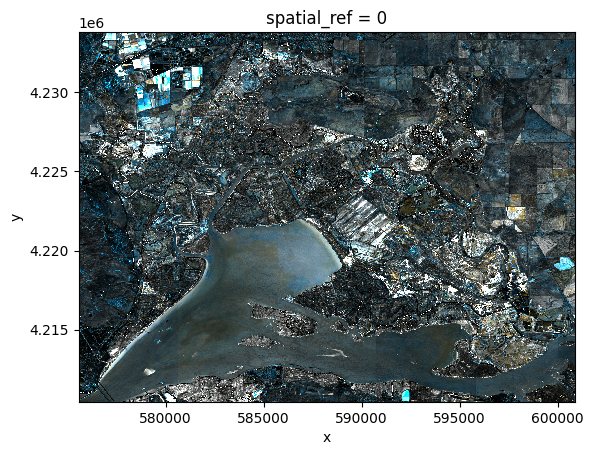

In [44]:
# verify output
out = rio.open_rasterio("Outputs/rmseAll.tif").to_dataset(dim='band') \
  .rename({1: 'rmse_all', 2: 'rmse_SOS', 3: 'rmse_POS', 4: 'rmse_EOS'})

out[['rmse_EOS', 'rmse_POS', 'rmse_SOS']].to_array().plot.imshow(robust=True)

#### Load chunked tiff and merge

In [69]:
files = glob.glob("Outputs/" + "LSP*")
files

['Outputs/LSP4.tif',
 'Outputs/LSP2.tif',
 'Outputs/LSP1.tif',
 'Outputs/LSP5.tif',
 'Outputs/LSP3.tif']

In [70]:
from rioxarray.merge import merge_arrays

pheno1 = rio.open_rasterio(files[0])
pheno2 = rio.open_rasterio(files[1])
pheno3 = rio.open_rasterio(files[2])
pheno4 = rio.open_rasterio(files[3])
pheno5 = rio.open_rasterio(files[4])

phenoAll = merge_arrays([pheno1.rio.write_crs('EPSG:32610'), pheno2.rio.write_crs('EPSG:32610'),
                         pheno3.rio.write_crs('EPSG:32610'), pheno4.rio.write_crs('EPSG:32610'), 
                         pheno5.rio.write_crs('EPSG:32610')])
phenoAll

<xarray.DataArray (band: 16, y: 2337, x: 2530)>
array([[[ 4.70000000e+01,  4.00000000e+01,  4.70000000e+01, ...,
          2.60000000e+01,  3.30000000e+01,  4.00000000e+01],
        [ 4.70000000e+01,  4.00000000e+01,  4.70000000e+01, ...,
          4.00000000e+01,  4.00000000e+01,  4.00000000e+01],
        [ 4.00000000e+01,  4.70000000e+01,  4.70000000e+01, ...,
          4.00000000e+01,  4.00000000e+01,  4.00000000e+01],
        ...,
        [ 1.03000000e+02,  1.03000000e+02,  1.10000000e+02, ...,
          8.90000000e+01,  9.60000000e+01,  1.03000000e+02],
        [ 1.03000000e+02,  1.03000000e+02,  1.03000000e+02, ...,
          1.17000000e+02,  1.10000000e+02,  1.03000000e+02],
        [ 1.03000000e+02,  1.03000000e+02,  1.03000000e+02, ...,
          1.17000000e+02,  1.10000000e+02,  9.60000000e+01]],

       [[ 8.90000000e+01,  8.90000000e+01,  9.60000000e+01, ...,
          8.90000000e+01,  8.90000000e+01,  8.90000000e+01],
        [ 8.90000000e+01,  8.90000000e+01,  9.60000000e+01, ...,
          8.90000000e+01,  8.90000000e+01,  8.90000000e+01],
        [ 8.90000000e+01,  9.60000000e+01,  9.60000000e+01, ...,
          8.90000000e+01,  8.90000000e+01,  8.90000000e+01],
...
        [-3.08124186e-03, -3.17867033e-03, -3.58595492e-03, ...,
         -5.23544391e-03, -2.96852810e-03, -4.24647476e-03],
        [-2.75602361e-03, -3.53464977e-03, -2.69766117e-03, ...,
         -3.19259549e-03, -3.17969981e-03, -6.97612291e-03],
        [-3.69555374e-03, -2.48142848e-03, -3.10328478e-03, ...,
         -2.65206581e-03, -3.42302671e-03, -2.99389856e-03]],

       [[-3.65519942e-01, -2.86029831e-01, -9.63815224e-02, ...,
         -8.43528011e-01, -8.16149044e-01, -7.53218236e-01],
        [-3.37643838e-01, -4.34930622e-01, -2.41419154e-01, ...,
         -7.42577039e-01, -5.92154511e-01, -4.67816719e-01],
        [-4.82830425e-01, -3.51398613e-01, -3.61313689e-01, ...,
         -4.41321490e-01, -5.74695594e-01, -4.46284155e-01],
        ...,
        [-8.28998528e-01, -9.07187198e-01, -1.07238960e+00, ...,
         -2.18005521e+00, -1.45605447e+00, -1.40770796e+00],
        [-1.05347275e+00, -1.06981252e+00, -1.05236588e+00, ...,
         -4.79078206e-02, -2.29225741e-01, -1.98683182e+00],
        [-1.13659694e+00, -9.64803284e-01, -1.06012685e+00, ...,
         -7.97829954e-02, -2.55182907e-01, -1.35823145e+00]]])
Coordinates:
  * x            (x) float64 5.756e+05 5.756e+05 ... 6.009e+05 6.009e+05
  * y            (y) float64 4.234e+06 4.234e+06 4.234e+06 ... 4.21e+06 4.21e+06
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('sos', 'pos', 'eos', 'vsos', 'vpos', 'veos', 'los', 'msp'...

In [ ]:
phenoAll.isel(band=1).plot(robust=True)

In [73]:
phenoAll.rio.to_raster("Outputs/lspAll.tif")